# 데이터 EDA

In [1]:
import sys

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [2]:
# 경로설정

CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'
FONT_PATH = COMMON_PATH / 'fonts' / 'NanumGothic.ttf'

In [3]:
font_prop = font_manager.FontProperties(fname=FONT_PATH)
rc('font', family=font_prop.get_name())

In [4]:
sys.path.append(str(COMMON_PATH))

In [5]:
import fn_loader as fn
import fn_config as fncfg

## Load data

In [6]:
# loader 생성 (데이터 로드 + multi index로 전처리)
pricevolume1 = fn.FnDataLoader('DBGAPS2024_pricevolume.xlsx') 

In [7]:
pricevolume1.dataguide_df.columns.levels[0]

Index(['shortterm', 'usd', 'usdinv', 'kodexinv', 'oil', 'gold', 'hybond',
       'midbond', '10y', 'csi300', 'nikkei', 'euro50', 'sp500', 'kosdaq150',
       'kodex200'],
      dtype='object')

In [8]:
pricevolume1.dataguide_df.columns.levels[1]

Index(['return', 'adjopen', 'adjhigh', 'adjlow', 'adjclose', 'moneyvolume'], dtype='object')

In [9]:
sid_list = np.array(pricevolume1.get_universe())
sid_list

array(['shortterm', 'usd', 'usdinv', 'kodexinv', 'oil', 'gold', 'hybond',
       'midbond', '10y', 'csi300', 'nikkei', 'euro50', 'sp500',
       'kosdaq150', 'kodex200'], dtype=object)

In [10]:
pricevolume1.get_datafields()

Index(['return', 'adjopen', 'adjhigh', 'adjlow', 'adjclose', 'moneyvolume'], dtype='object')

In [11]:
# 원하는 데이터를 2d 형태로 로드 (default로 nan 제거)
return_df = pricevolume1.get_data('return') # 
return_df.head() # Nikkei225랑 코스닥150이 nan이라 원래 2015-01-01부턴데 2016-03-04부터 시작

,shortterm,usd,usdinv,kodexinv,oil,gold,hybond,midbond,10y,csi300,nikkei,euro50,sp500,kosdaq150,kodex200
Date,,,,,,,,,,,,,,,
2016-03-04,0.00,-0.96,0.92,-0.12,1.27,1.83,0.37,-0.20,-0.19,0.42,0.19,-0.46,0.43,0.28,0.02
2016-03-07,0.00,-0.36,0.19,-0.24,4.58,-0.21,0.37,0.17,0.00,0.48,-0.24,-0.05,0.06,-0.51,0.21
2016-03-08,-0.01,0.45,-0.43,0.79,0.93,0.67,0.05,0.00,0.29,-0.89,-0.48,-0.05,-0.11,0.09,-0.70
2016-03-09,0.02,0.97,-0.82,-0.42,-1.45,-1.07,-0.05,-0.14,-0.05,-0.35,-1.00,-0.57,-0.21,0.60,0.43
2016-03-10,-0.01,-1.08,1.12,-0.73,1.74,-0.46,-0.10,0.19,-0.10,0.21,1.16,0.10,0.17,0.55,0.92


## 누적수익률

In [12]:
cum_return_df = (1 + return_df / 100).cumprod()

In [13]:
cum_return_without_inverse_df =  cum_return_df[[col for col in cum_return_df.columns if 'inv' not in col]].copy()
cum_return_without_inverse_df.replace([np.inf, -np.inf], np.nan, inplace=True)

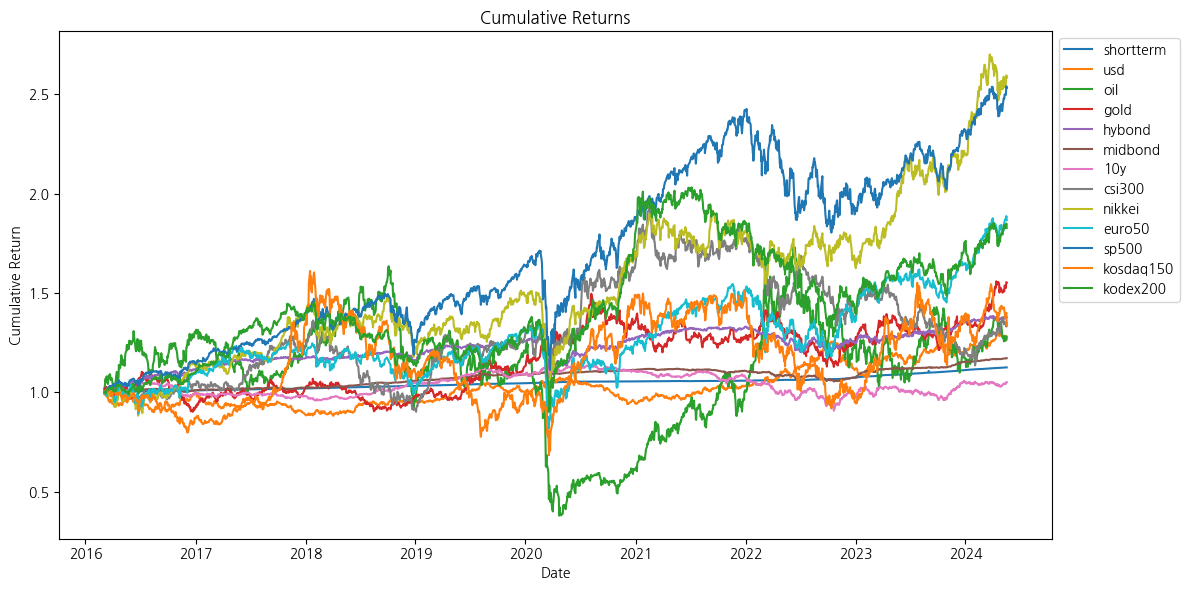

In [14]:
# Plot cumulative returns using matplotlib
plt.figure(figsize=(12, 6))  # Increase figure size

for column in cum_return_without_inverse_df.columns:
    plt.plot(cum_return_without_inverse_df.index, cum_return_without_inverse_df[column], label=column)

# Adjust the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside the plot

# Add title and labels if needed
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

# Display the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

## Corr

In [15]:
corr_df = return_df.corr()

In [16]:
return_without_inverse_df = return_df[[col for col in return_df.columns if 'inv' not in col]].copy()
sid_list_without_inverse = [sid for sid in sid_list if 'inv' not in sid]

C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2007796153.py:18: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2007796153.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2007796153.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2007796153.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

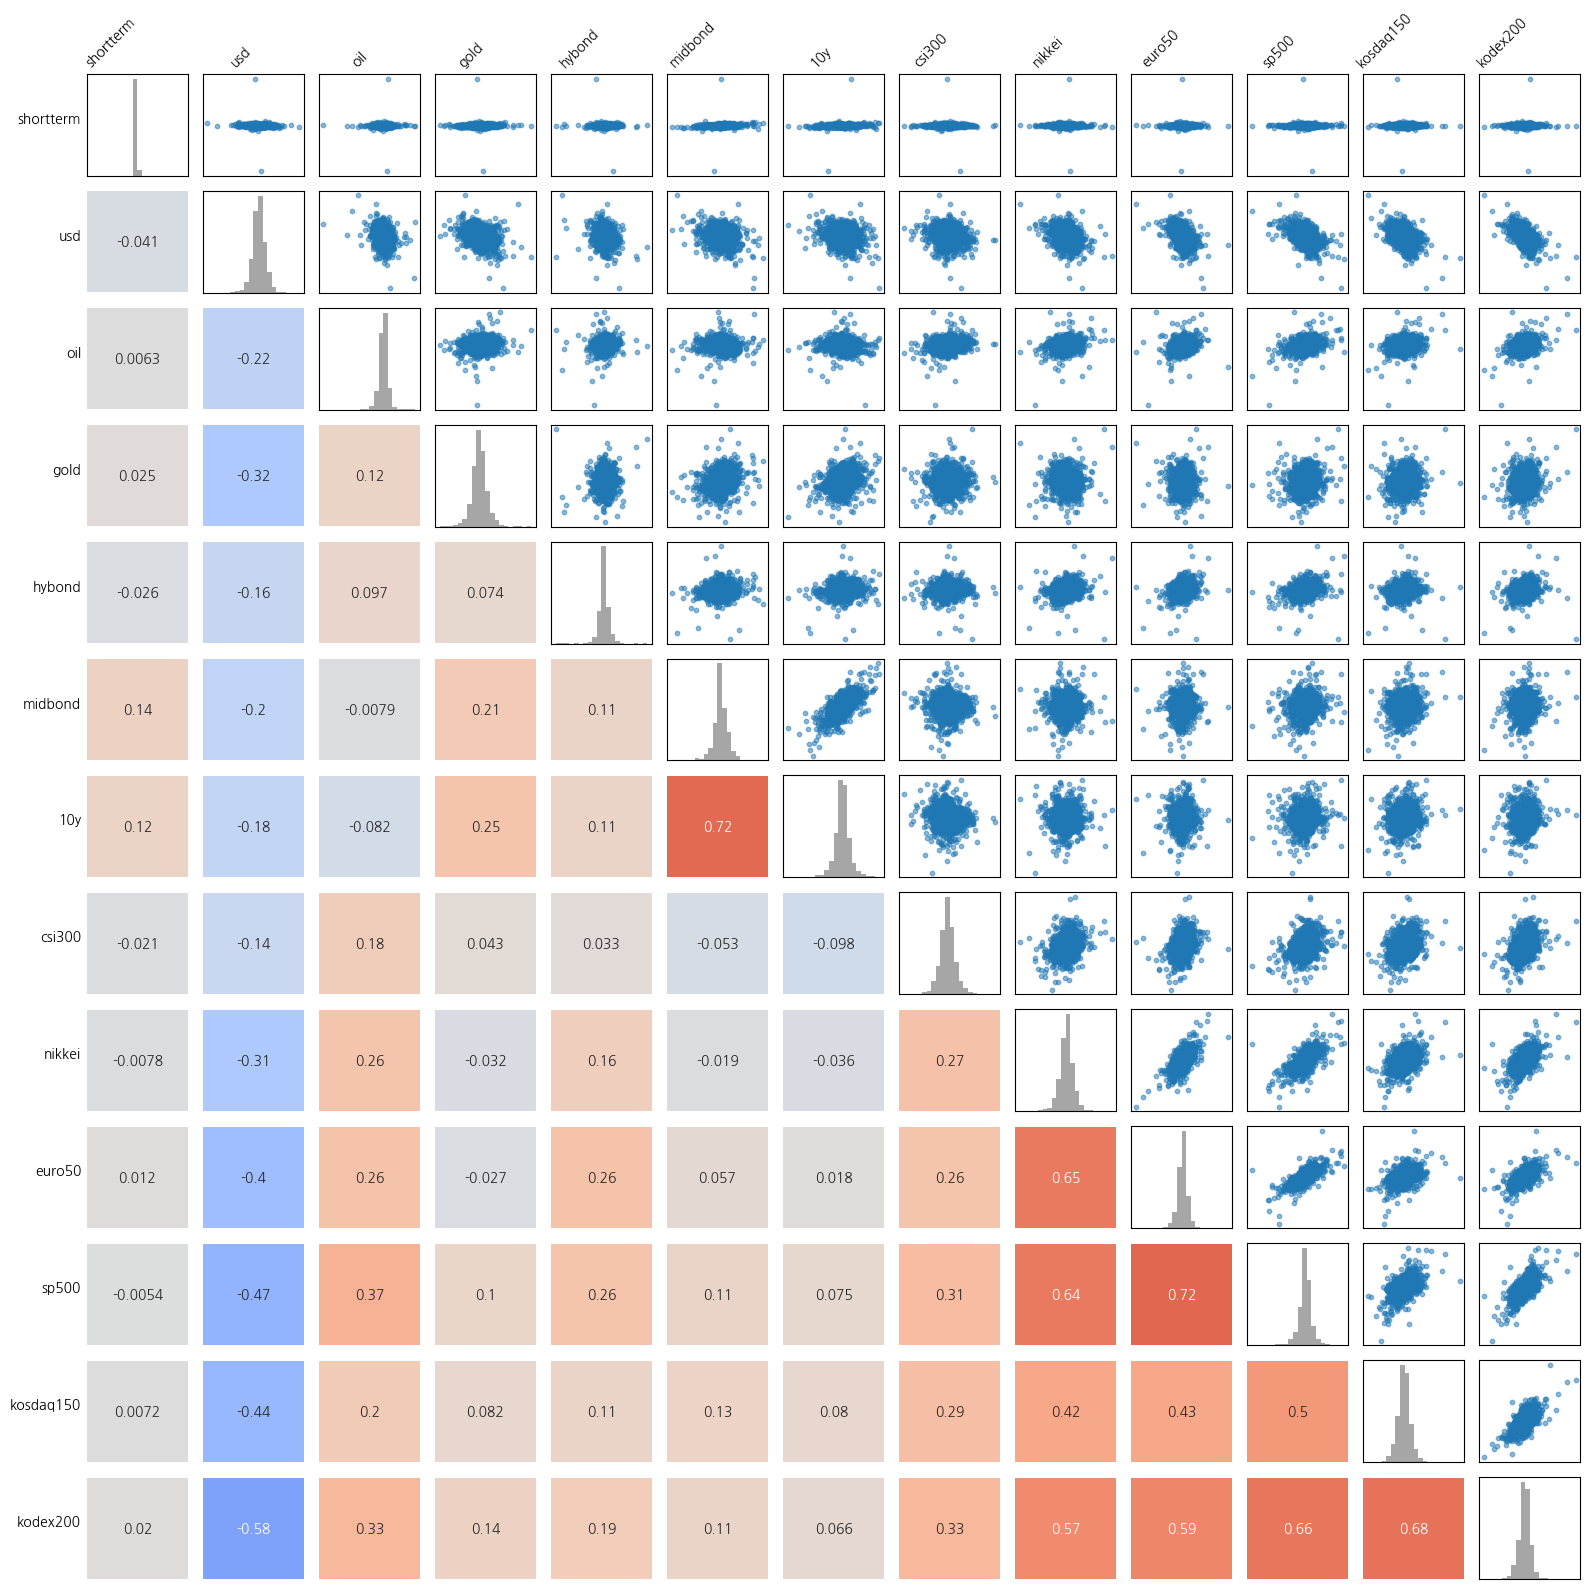

In [17]:
# Create a PairGrid-like plot using matplotlib
fig, axes = plt.subplots(nrows=len(sid_list_without_inverse), ncols=len(sid_list_without_inverse), figsize=(16, 16))

# Define a function to plot the lower triangle correlation heatmap with warning suppression
def plot_lower_triangle_heatmap(ax, data, x_col, y_col):
    with pd.option_context('mode.use_inf_as_na', True):
        corr = np.corrcoef(data[x_col], data[y_col])[0, 1]
        heatmap_data = np.array([[corr]])
        sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=True, cmap='coolwarm',
                    cbar=False, square=True, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

# Define a function to plot the diagonal histogram with warning suppression
def plot_diag_hist(ax, data, col):
    with pd.option_context('mode.use_inf_as_na', True):
        ax.hist(data[col], bins=20, color='gray', alpha=0.7)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

# Define a function to plot the upper triangle scatter plot with warning suppression
def plot_upper_triangle_scatter(ax, data, x_col, y_col):
    with pd.option_context('mode.use_inf_as_na', True):
        ax.scatter(data[x_col], data[y_col], alpha=0.5, s=10)  # s=10 makes the scatter plot points smaller
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

# Plot the data
for i in range(len(sid_list_without_inverse)):
    for j in range(len(sid_list_without_inverse)):
        ax = axes[i, j]
        if i > j:
            plot_lower_triangle_heatmap(ax, return_without_inverse_df, sid_list_without_inverse[j], sid_list_without_inverse[i])
        elif i == j:
            plot_diag_hist(ax, return_without_inverse_df, sid_list_without_inverse[i])
        elif i < j:
            plot_upper_triangle_scatter(ax, return_without_inverse_df, sid_list_without_inverse[j], sid_list_without_inverse[i])

# Add x-axis and y-axis labels for the entire plot
for ax, col in zip(axes[0], sid_list_without_inverse):
    ax.set_title(col, rotation=45, ha='right', fontsize=10)
for ax, row in zip(axes[:,0], sid_list_without_inverse):
    ax.set_ylabel(row, rotation=0, ha='right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
return_without_inverse_ytd_df = return_without_inverse_df.loc['2024-01-01':, :]
sid_list_without_inverse = [sid for sid in sid_list if 'inv' not in sid]

C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2423415806.py:18: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2423415806.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2423415806.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chlje\AppData\Local\Temp\ipykernel_37660\2423415806.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

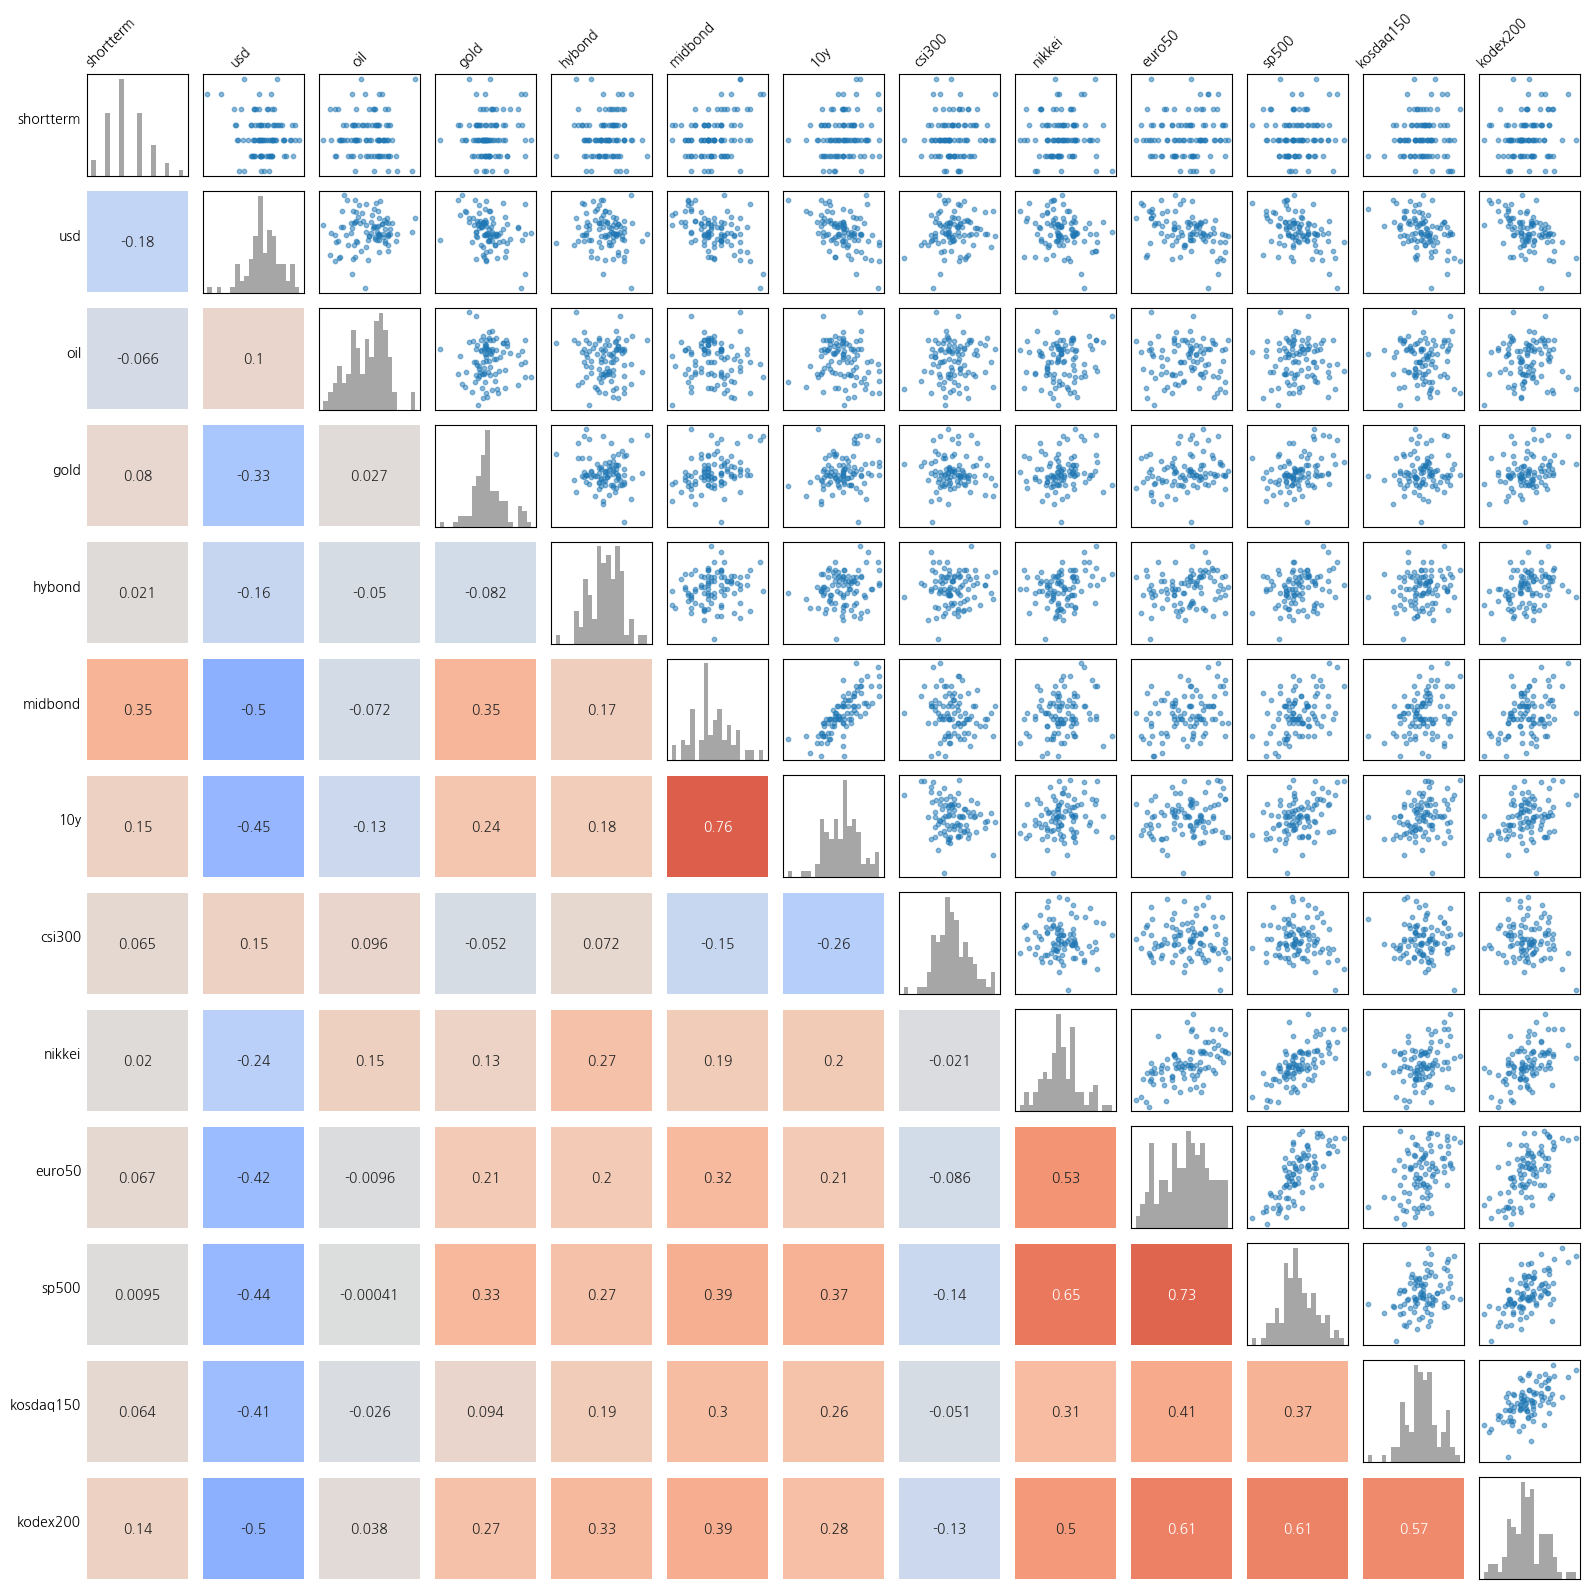

In [19]:
# Create a PairGrid-like plot using matplotlib
fig, axes = plt.subplots(nrows=len(sid_list_without_inverse), ncols=len(sid_list_without_inverse), figsize=(16, 16))

# Define a function to plot the lower triangle correlation heatmap with warning suppression
def plot_lower_triangle_heatmap(ax, data, x_col, y_col):
    with pd.option_context('mode.use_inf_as_na', True):
        corr = np.corrcoef(data[x_col], data[y_col])[0, 1]
        heatmap_data = np.array([[corr]])
        sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=True, cmap='coolwarm',
                    cbar=False, square=True, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

# Define a function to plot the diagonal histogram with warning suppression
def plot_diag_hist(ax, data, col):
    with pd.option_context('mode.use_inf_as_na', True):
        ax.hist(data[col], bins=20, color='gray', alpha=0.7)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

# Define a function to plot the upper triangle scatter plot with warning suppression
def plot_upper_triangle_scatter(ax, data, x_col, y_col):
    with pd.option_context('mode.use_inf_as_na', True):
        ax.scatter(data[x_col], data[y_col], alpha=0.5, s=10)  # s=10 makes the scatter plot points smaller
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

# Plot the data
for i in range(len(sid_list_without_inverse)):
    for j in range(len(sid_list_without_inverse)):
        ax = axes[i, j]
        if i > j:
            plot_lower_triangle_heatmap(ax, return_without_inverse_ytd_df, sid_list_without_inverse[j], sid_list_without_inverse[i])
        elif i == j:
            plot_diag_hist(ax, return_without_inverse_ytd_df, sid_list_without_inverse[i])
        elif i < j:
            plot_upper_triangle_scatter(ax, return_without_inverse_ytd_df, sid_list_without_inverse[j], sid_list_without_inverse[i])

# Add x-axis and y-axis labels for the entire plot
for ax, col in zip(axes[0], sid_list_without_inverse):
    ax.set_title(col, rotation=45, ha='right', fontsize=10)
for ax, row in zip(axes[:,0], sid_list_without_inverse):
    ax.set_ylabel(row, rotation=0, ha='right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()